# CoVid-19 Pandemic Statistics

Analysis of the CoVid-19 outbreak in Europe and comparison with _official_ data of the Hubei province, China

Total population of European countries taken from https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_in_Europe

Credits: a good part of this analysis is taken from
https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d


In [1]:
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Total population of some European countries of interest (Millions)
pop = {}
pop['Italy'] = 60
pop['France'] = 67
pop['Switzerland'] = 8.5
pop['Germany'] = 83
pop['Spain'] = 48
pop['United Kingdom'] = 66.4
pop['US'] = 50  #327 is the real count, but ~40% of the confirmed people are in New York, with 19.5M people
pop['Hubei'] = 58.5

In [16]:
# This is a Github repo with the official data from WHO
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

# these are the main data frames
df = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv')
#df = pd.read_csv(url + 'time_series_covid19_deaths_global.csv')
df[df['Country/Region'].isin(pop) & pd.isnull(df['Province/State'])]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
116,NaN,France,46.2276,2.2137,0,0,2,3,3,3,...,9043,10871,12612,14282,16018,19856,22304,25233,29155,32964
120,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,12327,15320,19848,22213,24873,29056,32986,37323,43938,50871
137,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,35713,41035,47021,53578,59138,63927,69176,74386,80589,86498
201,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,13910,17963,20410,25374,28768,35136,39885,49515,57786,65719
206,NaN,Switzerland,46.8182,8.2275,0,0,0,0,0,0,...,3028,4075,5294,6575,7474,8795,9877,10897,11811,12928
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,2626,2689,3983,5018,5683,6650,8077,9529,11658,14543
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,7783,13677,19100,25489,33276,43847,53740,65778,83836,101657


In [4]:
### Some data manipulation

# extract the countries of interest and prepare data
countrydf = {}
pop_no_Hubei = (set(pop.keys()) - {'Hubei'})
for c in pop_no_Hubei:
  # transpose + drop the first 4 fields (Prov, Country, Lat, Long)
  # + rename x axis label -> 'date' and data label -> country name
  countrydf[c] = df[(df['Country/Region'] == c) & pd.isnull(df['Province/State'])] \
                 .transpose()[4:] \
                 .reset_index() \
                 .rename(columns={'index': 'date', \
                                  df[(df['Country/Region'] == c) & pd.isnull(df['Province/State'])].index[0]: c})

# The provinces are different...
c = 'Hubei'
countrydf[c] = df[df['Province/State'] == c] \
               .transpose()[4:] \
               .reset_index() \
               .rename(columns={'index': 'date', \
                                df[df['Province/State'] == c].index[0]: c})

for c in pop:
  # convert date to days since Feb 29th
  countrydf[c]['date'] = countrydf[c]['date'].map(lambda d : \
        (datetime.strptime(d, '%m/%d/%y') - datetime.strptime('2020-02-29','%Y-%m-%d')).days)
  # convert #cases to cases per 1M inhabitants
  countrydf[c][c] /= pop[c]

countrydf['United Kingdom'].tail()

,date,United Kingdom
61,23,5.04518
62,24,6.35542
63,25,7.00301
64,26,8.70482
65,27,11.4307


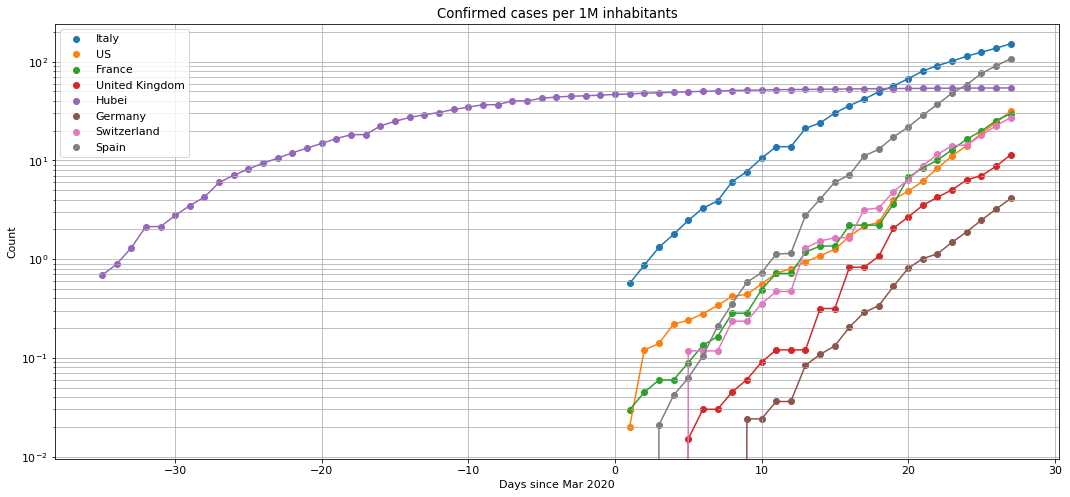

In [5]:
plt.rcParams['figure.figsize'] = [18, 8]
plt.rc('font', size=11)

for c in pop:
  # drop first days' data as it's more noisy: keep points with value > 0.5 cases / 1M people
  countrydf[c] = countrydf[c][countrydf[c].gt(0.5).any(axis=1)]

  # get all data points
  t = list(countrydf[c].iloc[:, 0]) 
  y = list(countrydf[c].iloc[:, 1])
  plt.scatter(t, y, label=c)   # draw the dots
  plt.plot(t, y)   # draw the lines

plt.legend()
plt.title("Confirmed cases per 1M inhabitants")
plt.xlabel("Days since Mar 2020")
plt.ylabel("Count")
#plt.ylim((6e2, 2e3))
plt.yscale('log')
plt.grid(which='both')
plt.show()

# Models and curves fitting

Now let's try to fit the data. How do we model such a growth?

## Geometric or Exponential growth

Many natural phenomena follow geometric or exponential evolutions. Examples:
* Radioactive decay
* Population growth (or virus spreading)

WHY?

Each time the difference (for example, the daily growth) is proportional to the entire set, the resulting evolution is a geometric or exponential sequence!

Population growth:
  $$\Delta N(d) = N(d+1) - N(d) = k\cdot N(d)$$
  
Radioactive decay (the negative sign accounts for the fact that the decayed atoms disappear from the total):
  $$N_{decaying}(t) = \Delta N(t) = N_{total}(t) - N_{total}(t-1) = - k\cdot N_{total}(t)$$

Solving the first:
  $$N(d+1) = (k + 1)\cdot N(d) = (k + 1)^{2}\cdot N(d-1) = \cdots = (k + 1)^{d}\cdot N(0)$$

It is a common convention in Math to express any exponential function in terms of the _e_ constant, by redefining the other factors:

$$(k+1)^{d} = e^{d/\tau}, \quad \tau \equiv \frac{1}{ln(k+1)}$$

Therefore, a generic exponential function is:

  $$f_{a,b,\tau}(t) = a\cdot e^{(t-b)/\tau} \quad a, b, \tau \; free \; parameters$$

Let's have a look at it with some plots.

In [6]:
def exp_model(t, a, b, tau):
  return a*np.exp((t-b)/tau)

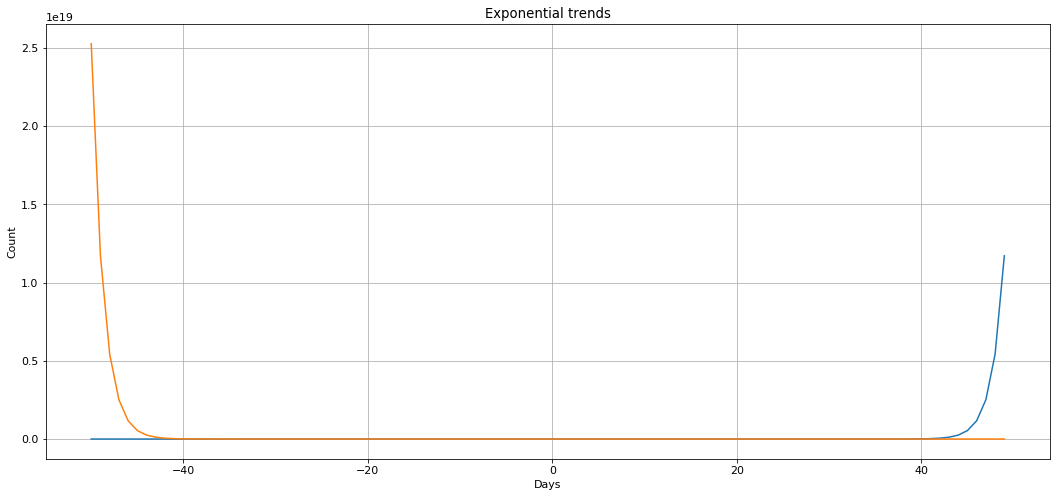

In [7]:
t_range = list(range(-50, +50))
plt.plot(t_range, [exp_model(i, 500, 0, 1.3) for i in t_range])
plt.plot(t_range, [exp_model(i, 500, 0, -1.3) for i in t_range])

plt.title("Exponential trends")
plt.xlabel("Days")
plt.ylabel("Count")
#plt.yscale('log')
plt.grid(which='both')
plt.show()

## Back to our data

Now let's try and fit our data with those functions, that is find the parameters for our functions that "best" match the given data points.

WARNING: data fitting and model identification is a large and complex topic in Data Science and Statistics. Here the tools to perform some fits are shown to illustrate how easy it is to experiment with the data, but the scientist has to always challenge the model before reaching any conclusions!

Paraphrasing Socrates (_Gnoti seauthon_, "know yourself"), know your data!

In [8]:
exp_fit = {}
for c in pop:
  t = list(countrydf[c].iloc[:,0])
  y = list(countrydf[c].iloc[:,1])
  try:
    exp_fit[c] = curve_fit(exp_model, t, y, p0=[0.01, 0.5, 3])
  except RuntimeError:
    exp_fit[c] = None

exp_fit     # parameters of the fit: note how many useless decimal digits. The Covariance Matrix is given as result

{'France': (array([0.06471943, 0.29566787, 4.32674966]),
  array([[ 1.43402030e+08,  9.58699239e+09, -3.55904401e+02],
         [ 9.58699239e+09,  6.40928326e+11, -2.37936847e+04],
         [-3.55904405e+02, -2.37936850e+04,  1.28370032e-02]])),
 'Germany': (array([ 1.96947653e-04, -1.18873978e+01,  3.90724823e+00]),
  array([[ 1.30561179e+04,  2.58928001e+08, -1.38616338e+00],
         [ 2.58928001e+08,  5.13504171e+12, -2.74903240e+04],
         [-1.38616501e+00, -2.74903563e+04,  3.33163134e-03]])),
 'Hubei': (array([   0.30039094, -196.33514084,   41.16875315]),
  array([[-4.93434596e+13, -6.76254990e+15, -2.49600327e+07],
         [-6.76254990e+15, -9.26811404e+17, -3.42078709e+09],
         [-2.49600327e+07, -3.42078709e+09,  0.00000000e+00]])),
 'Italy': (array([  0.08952762, -27.62881595,   7.27700239]),
  array([[1.11765981e+10, 9.08458563e+11, 2.58858498e+02],
         [9.08458563e+11, 7.38415171e+13, 2.10401162e+04],
         [2.58859159e+02, 2.10401699e+04, 6.69898430e-02]]

In [9]:
tdoubling = {}
for c in pop_no_Hubei:
  tdoubling[c] = int(10*exp_fit[c][0][2]*np.log(2))/10.0
tdoubling

{'France': 2.9,
 'Germany': 2.7,
 'Italy': 5.0,
 'Spain': 3.0,
 'Switzerland': 3.3,
 'US': 2.6,
 'United Kingdom': 3.1}

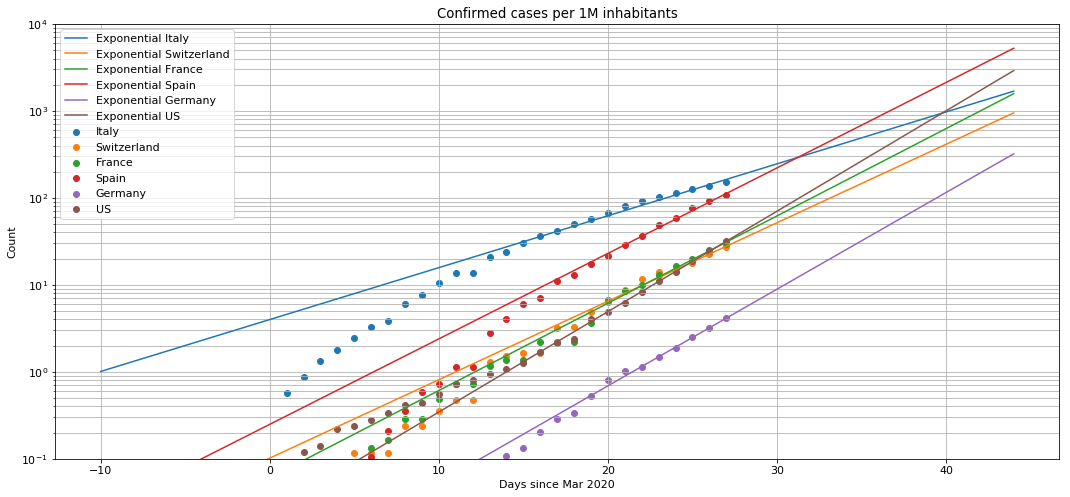

In [10]:
t_fit = list(range(-10, +45))

for c in ('Italy', 'Switzerland', 'France', 'Spain', 'Germany', 'US'):
  # Real data
  t = list(countrydf[c].iloc[:, 0])
  y = list(countrydf[c].iloc[:, 1])
  plt.scatter(t, y, label=c)

  # Predicted exponential curve
  if exp_fit[c]:
    plt.plot(t_fit, [exp_model(i, exp_fit[c][0][0],exp_fit[c][0][1],exp_fit[c][0][2]) for i in t_fit],
             label=("Exponential %s" % c))

plt.legend()
plt.title("Confirmed cases per 1M inhabitants")
plt.xlabel("Days since Mar 2020")
plt.ylabel("Count")
plt.ylim((0.1, 1e4))
plt.yscale('log')
plt.grid(which='both')
plt.show()

## Advanced: a realistic model

If we want to take into account that the population size is not infinite, a more realistic model is given by the "logistic" (or sigmoid) function:

  $$f_{a,b,c}(\tau) = \frac{a}{1+e^{-(t-b)/\tau}} \quad a \equiv P_{final}\$$

The derivation of this formula goes beyond the scope of this tutorial. See e.g. https://en.wikipedia.org/wiki/Logistic_regression for further details.

Let's have a look at this one too.

In [11]:
def logistic_model(t, a, b, tau):
  return a/(1+np.exp(-(t-b)/tau))

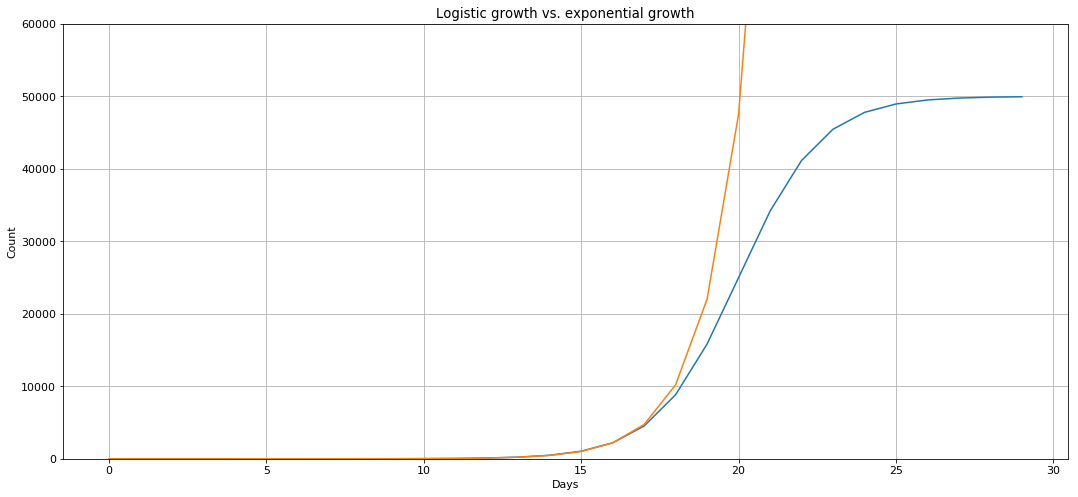

In [12]:
t_range = list(range(0, +30))
plt.plot(t_range, [logistic_model(i, 50000, 20, 1.3) for i in t_range])
plt.plot(t_range, [exp_model(i, 1, 6, 1.3) for i in t_range])

plt.title("Logistic growth vs. exponential growth")
plt.xlabel("Days")
plt.ylabel("Count")
plt.ylim((0.1, 6e4))
#plt.yscale('log')
plt.grid(which='both')
plt.show()

In [13]:
logit_fit = {}
for c in pop:
  t = list(countrydf[c].iloc[:,0])
  y = list(countrydf[c].iloc[:,1])
  try:
    logit_fit[c] = curve_fit(logistic_model, t, y, p0=[1000, 40, 3])
  except RuntimeError:
    try:
      logit_fit[c] = curve_fit(logistic_model, t, y, p0=[10000, 60, 3])
    except RuntimeError:
      logit_fit[c] = None

logit_fit     # parameters of the fit and Covariance Matrix

{'France': (array([68.0671815 , 27.82022685,  3.31925454]),
  array([[9.05496595e+01, 7.75752458e+00, 1.36452632e+00],
         [7.75752458e+00, 6.69286728e-01, 1.20119065e-01],
         [1.36452632e+00, 1.20119065e-01, 2.39325886e-02]])),
 'Germany': (array([39.7180237 , 35.0102663 ,  3.70861184]),
  array([[8.18206974e+02, 9.36194322e+01, 4.18939425e+00],
         [9.36194322e+01, 1.07308813e+01, 4.86357453e-01],
         [4.18939425e+00, 4.86357453e-01, 2.41534002e-02]])),
 'Hubei': (array([ 53.35636606, -13.69582014,   6.5094656 ]),
  array([[0.03515656, 0.01271982, 0.01003352],
         [0.01271982, 0.01314479, 0.00354096],
         [0.01003352, 0.00354096, 0.00973916]])),
 'Italy': (array([225.52982632,  23.86791172,   4.60125622]),
  array([[5.66325078e+01, 2.43968493e+00, 6.89554774e-01],
         [2.43968493e+00, 1.06740793e-01, 3.05166710e-02],
         [6.89554774e-01, 3.05166710e-02, 1.02185016e-02]])),
 'Spain': (array([234.92494549,  27.56559494,   3.34502034]),
  array([

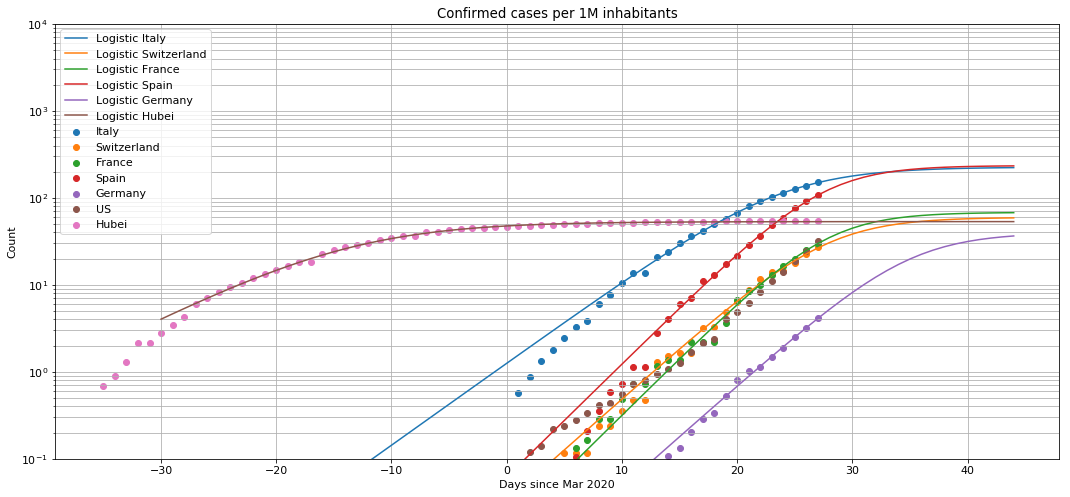

In [14]:
t_fit = list(range(-30, +45))

show_exp = False

for c in ('Italy', 'Switzerland', 'France', 'Spain', 'Germany', 'US', 'Hubei'):
  # Real data
  t = list(countrydf[c].iloc[:, 0])
  y = list(countrydf[c].iloc[:, 1])
  plt.scatter(t, y, label=c)

  if show_exp:
    # Predicted exponential curve
    if exp_fit[c]:
      plt.plot(t_fit, [exp_model(i, exp_fit[c][0][0],exp_fit[c][0][1],exp_fit[c][0][2]) for i in t_fit],
               label=("Exponential %s" % c))
  else:
    # Predicted logistic curve
    if logit_fit[c]:
      plt.plot(t_fit, [logistic_model(i, logit_fit[c][0][0],logit_fit[c][0][1],logit_fit[c][0][2]) for i in t_fit],
               label=("Logistic %s" % c))

plt.legend()
plt.title("Confirmed cases per 1M inhabitants")
plt.xlabel("Days since Mar 2020")
plt.ylabel("Count")
plt.ylim((0.1, 1e4))
plt.yscale('log')
plt.grid(which='both')
plt.show()